
=== 增强版 APF 参数设置 ===
✅ 当前随机种子: 1830366393

起点: [2.3116265  8.38923319]
目标点: [10.60956077 15.79232912]
障碍物数量: 15
⚠️ 达到最大迭代次数，可能仍存在局部最小值 轨迹点数: 12001


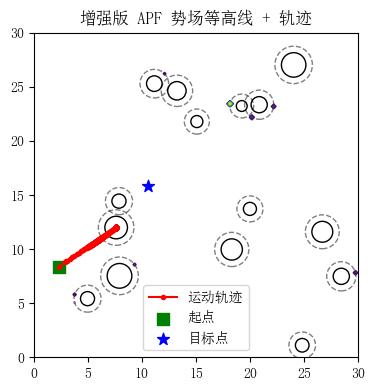

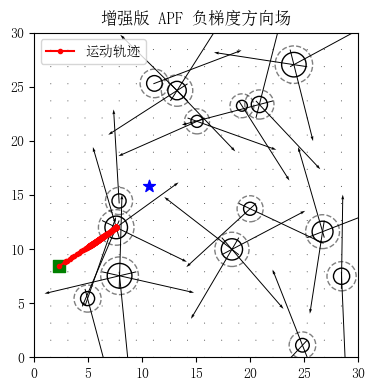

In [6]:
"""
=========================================================
人工势场法 (Artificial Potential Field, APF) 避障算法 — 增强版
=========================================================
功能说明：
1. 随机生成起点、目标点和障碍物；
2. 吸引势(远处二次、近处线性) + 排斥势(障碍膨胀 + 平滑)；
3. 自适应步长 + 回溯线搜索；
4. 局部极小逃逸(绕障切向推进 + 少量噪声)；
5. 轨迹平滑(端点不动的滑动均值)；
6. 可视化势场等高线/方向场与轨迹。
---------------------------------------------------------
作者：ChatGPT GPT-5 优化版
日期：2025-11-10
---------------------------------------------------------
"""

import time
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = ["SimSun", "SimHei", "Microsoft YaHei"]  # 宋体、黑体、微软雅黑\n
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题\n",
# =========================================================
# 1️⃣ 环境生成函数
# =========================================================
def generate_environment(xmin, xmax, ymin, ymax, min_goal_dist=5.0,
                         num_obs_range=(10, 20), seed=None):
    """随机生成起点、目标点和障碍物"""
    if seed is None:
        seed = int(time.time() * 1000) % (2**32 - 1)
    np.random.seed(seed)
    print(f"✅ 当前随机种子: {seed}")

    while True:
        start = np.random.uniform([xmin+1, ymin+1], [xmax-1, ymax-1])
        goal = np.random.uniform([xmin+1, ymin+1], [xmax-1, ymax-1])
        if np.linalg.norm(start - goal) > min_goal_dist:
            break

    num_obs = np.random.randint(*num_obs_range)
    obstacles = []
    for _ in range(num_obs):
        while True:
            ox, oy = np.random.uniform(xmin+1, xmax-1), np.random.uniform(ymin+1, ymax-1)
            r = np.random.uniform(0.5, 1.2)
            if (np.linalg.norm(start - [ox, oy]) > r + 0.5 and
                np.linalg.norm(goal - [ox, oy]) > r + 0.5):
                obstacles.append((ox, oy, r))
                break

    return start, goal, obstacles


def inflate_obstacles(obstacles, margin):
    """对障碍物做几何膨胀，提升安全裕度与可达率"""
    if margin <= 0:
        return obstacles
    inflated = []
    for (ox, oy, r) in obstacles:
        inflated.append((ox, oy, r + margin))
    return inflated


# =========================================================
# 2️⃣ 势场函数（增强）
# =========================================================
def attractive_potential(pos, goal, k_att, goal_linear_thresh=1.5):
    """吸引势：远处二次，近处线性，降低目标附近振荡与穿越障碍的冲动"""
    d = np.linalg.norm(pos - goal)
    if d <= goal_linear_thresh:
        return k_att * d
    else:
        return 0.5 * k_att * d * d


def attractive_gradient(pos, goal, k_att, goal_linear_thresh=1.5, eps=1e-9):
    """对应的梯度：远处线性增长，近处归一化方向向量"""
    vec = pos - goal
    d = np.linalg.norm(vec)
    if d <= eps:
        return np.zeros(2)
    if d <= goal_linear_thresh:
        return k_att * (vec / d)
    else:
        return k_att * vec


def repulsive_potential(pos, obstacles, k_rep, rho_0):
    """排斥势：使用膨胀后的障碍半径，靠近时平滑增长"""
    U = 0.0
    for (ox, oy, r) in obstacles:
        d = np.linalg.norm(pos - np.array([ox, oy]))
        rho = d - r
        if rho <= 0:
            return 1e6
        elif rho <= rho_0:
            # 经典形式，已较为平滑
            U += 0.5 * k_rep * (1.0 / rho - 1.0 / rho_0) ** 2
    return U


def repulsive_gradient(pos, obstacles, k_rep, rho_0, eps=1e-9):
    """排斥势梯度：对靠近障碍时的方向与幅值进行稳定化处理"""
    grad = np.zeros(2)
    for (ox, oy, r) in obstacles:
        center = np.array([ox, oy])
        vec = pos - center
        d = np.linalg.norm(vec)
        rho = d - r
        if d <= eps:
            continue
        if rho <= 0:
            grad += 1e6 * vec / d
        elif rho <= rho_0:
            coef = k_rep * (1.0 / rho - 1.0 / rho_0) * (1.0 / (rho ** 2))
            # 限幅，避免极端近距离产生数值不稳定
            coef = np.clip(coef, -1e4, 1e4)
            grad += coef * (vec / d)
    return grad


def total_potential(pos, goal, obstacles, k_att, k_rep, rho_0, goal_linear_thresh):
    return (attractive_potential(pos, goal, k_att, goal_linear_thresh)
            + repulsive_potential(pos, obstacles, k_rep, rho_0))


def total_gradient(pos, goal, obstacles, k_att, k_rep, rho_0, goal_linear_thresh):
    return (attractive_gradient(pos, goal, k_att, goal_linear_thresh)
            + repulsive_gradient(pos, obstacles, k_rep, rho_0))


# =========================================================
# 3️⃣ 轨迹平滑 & 辅助工具
# =========================================================
def smooth_path(points, passes=2, window=3):
    """简单滑动均值平滑，首尾固定"""
    if len(points) <= 2:
        return np.asarray(points)
    pts = np.asarray(points, dtype=float).copy()
    for _ in range(max(0, int(passes))):
        new_pts = pts.copy()
        for i in range(1, len(pts) - 1):
            left = max(0, i - window)
            right = min(len(pts), i + window + 1)
            new_pts[i] = pts[left:right].mean(axis=0)
        pts = new_pts
    pts[0] = points[0]
    pts[-1] = points[-1]
    return pts


def nearest_obstacle(pos, obstacles):
    idx, best = -1, float('inf')
    for k, (ox, oy, r) in enumerate(obstacles):
        d = np.linalg.norm(pos - np.array([ox, oy])) - r
        if d < best:
            best, idx = d, k
    return idx


# =========================================================
# 4️⃣ 模拟移动（增强）
# =========================================================
def simulate_apf(start, goal, obstacles, k_att, k_rep, rho_0,
                 step_size=0.2, tol=0.25, max_iters=12000,
                 goal_linear_thresh=1.5,
                 obstacle_inflate=0.6,
                 backtrack_factor=0.5,
                 grow_factor=1.05,
                 min_step=0.02,
                 max_step=0.8,
                 stagnation_window=60,
                 stagnation_tol=1e-3,
                 noise_scale=0.05,
                 tangent_gain=0.25,
                 smooth_passes=3):
    """基于增强势场的路径规划，提升到达率并降低局部极小风险"""
    pos = np.array(start, dtype=float)
    inflated_obs = inflate_obstacles(obstacles, obstacle_inflate)

    step = float(step_size)
    best_dist = np.linalg.norm(pos - goal)
    recent = [best_dist]

    trajectory = [pos.copy()]
    U_prev = total_potential(pos, goal, inflated_obs, k_att, k_rep, rho_0, goal_linear_thresh)

    for it in range(max_iters):
        # 终止条件
        if np.linalg.norm(pos - goal) <= tol:
            smoothed = smooth_path(trajectory, passes=smooth_passes)
            return np.asarray(smoothed), "✅ 成功到达目标点"

        grad = total_gradient(pos, goal, inflated_obs, k_att, k_rep, rho_0, goal_linear_thresh)
        grad_norm = np.linalg.norm(grad) + 1e-12

        # 基本更新方向（负梯度）
        direction = -grad / grad_norm

        # 局部极小逃逸：若进展停滞，则添加切向分量绕最近障碍前进
        if len(recent) >= stagnation_window and (recent[0] - recent[-1]) < stagnation_tol:
            idx = nearest_obstacle(pos, inflated_obs)
            if idx >= 0:
                ox, oy, r = inflated_obs[idx]
                # 切向方向：将指向障碍中心的方向旋转 90°
                to_center = np.array([ox, oy]) - pos
                if np.linalg.norm(to_center) > 1e-12:
                    normal = to_center / np.linalg.norm(to_center)
                    tangent = np.array([ -normal[1], normal[0] ])
                    # 与原负梯度融合
                    direction = (direction + tangent_gain * tangent)
                    nrm = np.linalg.norm(direction)
                    if nrm > 1e-12:
                        direction = direction / nrm
            # 注入少量随机性，帮助跳出鞍点/极小
            direction += noise_scale * (np.random.rand(2) - 0.5)
            nrm = np.linalg.norm(direction)
            if nrm > 1e-12:
                direction = direction / nrm

        # 自适应步长 + 回溯线搜索：若势能上升，回退步长
        tentative = pos + step * direction
        U_new = total_potential(tentative, goal, inflated_obs, k_att, k_rep, rho_0, goal_linear_thresh)
        backtracked = False
        while U_new > U_prev and step > min_step:
            step *= backtrack_factor
            tentative = pos + step * direction
            U_new = total_potential(tentative, goal, inflated_obs, k_att, k_rep, rho_0, goal_linear_thresh)
            backtracked = True

        # 若下降成功且非回溯，适度增大步长，提高收敛效率
        if not backtracked:
            step = min(max_step, step * grow_factor)

        pos = tentative
        trajectory.append(pos.copy())

        # 更新进展记录
        cur_dist = np.linalg.norm(pos - goal)
        best_dist = min(best_dist, cur_dist)
        recent.append(cur_dist)
        if len(recent) > stagnation_window:
            recent.pop(0)
        U_prev = U_new

    # 达到迭代上限，仍做平滑返回
    smoothed = smooth_path(trajectory, passes=smooth_passes)
    return np.asarray(smoothed), "⚠️ 达到最大迭代次数，可能仍存在局部最小值"


# =========================================================
# 5️⃣ 可视化函数
# =========================================================
def plot_potential_field(xmin, xmax, ymin, ymax, goal, obstacles, trajectory, k_att, k_rep, rho_0, goal_linear_thresh, obstacle_inflate):
    nx, ny = 120, 120
    xs, ys = np.linspace(xmin, xmax, nx), np.linspace(ymin, ymax, ny)
    X, Y = np.meshgrid(xs, ys)
    U = np.zeros_like(X)

    inflated_obs = inflate_obstacles(obstacles, obstacle_inflate)

    for i in range(nx):
        for j in range(ny):
            p = np.array([X[j, i], Y[j, i]])
            U[j, i] = total_potential(p, goal, inflated_obs, k_att, k_rep, rho_0, goal_linear_thresh)

    fig, ax = plt.subplots(figsize=(6, 4))
    contour = ax.contour(X, Y, U, levels=30)
    ax.clabel(contour, inline=True, fontsize=8)
    traj = np.array(trajectory)
    ax.plot(traj[:, 0], traj[:, 1], 'r.-', label='运动轨迹')
    ax.scatter(traj[0, 0], traj[0, 1], c='g', s=80, marker='s', label='起点')
    ax.scatter(goal[0], goal[1], c='b', s=80, marker='*', label='目标点')

    for (ox, oy, r) in obstacles:
        ax.add_patch(plt.Circle((ox, oy), r, fill=False, color='k', linewidth=1.0))
    for (ox, oy, r) in inflated_obs:
        ax.add_patch(plt.Circle((ox, oy), r, fill=False, color='k', linestyle='--', alpha=0.5))

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_aspect('equal')
    ax.legend()
    ax.set_title("增强版 APF 势场等高线 + 轨迹")
    plt.tight_layout()
    plt.show()


def plot_gradient_field(xmin, xmax, ymin, ymax, goal, obstacles, trajectory, k_att, k_rep, rho_0, goal_linear_thresh, obstacle_inflate):
    nx, ny = 20, 20
    xs, ys = np.linspace(xmin, xmax, nx), np.linspace(ymin, ymax, ny)
    X, Y = np.meshgrid(xs, ys)
    Ugx, Ugy = np.zeros_like(X), np.zeros_like(Y)

    inflated_obs = inflate_obstacles(obstacles, obstacle_inflate)

    for i in range(nx):
        for j in range(ny):
            g = total_gradient(np.array([X[j, i], Y[j, i]]), goal, inflated_obs, k_att, k_rep, rho_0, goal_linear_thresh)
            Ugx[j, i], Ugy[j, i] = -g[0], -g[1]

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.quiver(X, Y, Ugx, Ugy)
    traj = np.array(trajectory)
    ax.plot(traj[:, 0], traj[:, 1], 'r.-', label='运动轨迹')
    ax.scatter(traj[0, 0], traj[0, 1], c='g', s=80, marker='s')
    ax.scatter(goal[0], goal[1], c='b', s=80, marker='*')

    for (ox, oy, r) in obstacles:
        ax.add_patch(plt.Circle((ox, oy), r, fill=False, color='k', linewidth=1.0))
    for (ox, oy, r) in inflated_obs:
        ax.add_patch(plt.Circle((ox, oy), r, fill=False, color='k', linestyle='--', alpha=0.5))

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_aspect('equal')
    ax.legend()
    ax.set_title("增强版 APF 负梯度方向场")
    plt.tight_layout()
    plt.show()


# =========================================================
# 6️⃣ 主程序入口（可调参数）
# =========================================================
if __name__ == "__main__":
    print("\n=== 增强版 APF 参数设置 ===")
    # 势场参数
    k_att = 8.0
    k_rep = 250.0
    rho_0 = 8.0
    goal_linear_thresh = 1.5

    # 运动/数值参数
    step_size = 0.25
    min_step = 0.02
    max_step = 0.8
    backtrack_factor = 0.5
    grow_factor = 1.05

    # 几何/鲁棒性
    obstacle_inflate = 0.6
    tangent_gain = 0.25
    noise_scale = 0.05
    stagnation_window = 60
    stagnation_tol = 1e-3

    # 平滑
    smooth_passes = 3

    xmin, xmax, ymin, ymax = 0, 30, 0, 30
    start, goal, obstacles = generate_environment(xmin, xmax, ymin, ymax)

    trajectory, status = simulate_apf(
        start, goal, obstacles,
        k_att, k_rep, rho_0,
        step_size=step_size,
        tol=0.25,
        max_iters=12000,
        goal_linear_thresh=goal_linear_thresh,
        obstacle_inflate=obstacle_inflate,
        backtrack_factor=backtrack_factor,
        grow_factor=grow_factor,
        min_step=min_step,
        max_step=max_step,
        stagnation_window=stagnation_window,
        stagnation_tol=stagnation_tol,
        noise_scale=noise_scale,
        tangent_gain=tangent_gain,
        smooth_passes=smooth_passes,
    )

    print(f"\n起点: {start}\n目标点: {goal}\n障碍物数量: {len(obstacles)}")
    print(status, f"轨迹点数: {len(trajectory)}")

    plot_potential_field(
        xmin, xmax, ymin, ymax,
        goal, obstacles, trajectory,
        k_att, k_rep, rho_0,
        goal_linear_thresh,
        obstacle_inflate,
    )
    plot_gradient_field(
        xmin, xmax, ymin, ymax,
        goal, obstacles, trajectory,
        k_att, k_rep, rho_0,
        goal_linear_thresh,
        obstacle_inflate,
    )
